# Model comparison using distance metrics

In [1]:
import os
import pickle
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Pathing
data_folder = '/home/diego/data/dm/stac/results/JDM25_v6'
files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if '.p' in f]

# Load list of dictionaries
data = [pickle.load(open(f, 'rb')) for f in files]


## Helper class for rat analysis

In [3]:
class rat_analysis():
    def __init__(self, snip):
        self.snip = snip
        self.mocap_names = [k for k in self.snip['_KEYPOINT_MODEL_PAIRS'].keys()]
        self.parts = {'arms': self._get_parts(['Arm', 'Elbow', 'Shoulder']),
         'legs': self._get_parts(['Shin', 'Knee', 'Hip']),
         'head': self._get_parts(['Head']),
         'body': self._get_parts(['Spine', 'Offset']),
         'total': self.mocap_names
        }
        self.links = [
            ('HeadF', 'HeadB'),
            ('HeadF', 'HeadL' ),
            ('HeadF', 'SpineF'),
            ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'),
            ('HeadL', 'SpineF'),
            ('SpineF', 'SpineM'),
            ('SpineF', 'Offset1'),
            ('SpineF', 'ShoulderR'),
            ('SpineF', 'ShoulderL'),
            ('ShoulderR', 'ElbowR'),
            ('ShoulderL', 'ElbowL'),
            ('ElbowR', 'ArmR'),
            ('ElbowL', 'ArmL'),
            ('SpineM', 'SpineL'),
            ('SpineM', 'Offset2'),
            ('Offset2', 'SpineL'),
            ('SpineL', 'HipL' ),
            ('SpineL', 'HipR'),
            ('HipR', 'KneeR'),
            ('HipL', 'KneeL'),
            ('KneeR', 'ShinR'),
            ('KneeL', 'ShinL')]

        self._marker_ids = {}
        for marker_id, val in enumerate(self.mocap_names):
            self._marker_ids[val] = marker_id*3 + np.array([0, 1, 2])
        self.kp_data = self.snip['kp_data']
        self.walker_body_sites = []
        for sitepos in self.snip['walker_body_sites']:
            self.walker_body_sites.append(sitepos.flatten())
        self.walker_body_sites = np.stack(self.walker_body_sites, axis=1).T  
        self.qpos = self.snip['qpos']
        
    def _get_parts(self, partnames):
        return [name for name in self.mocap_names if any(part in name for part in partnames)]
    
    def p_ids(self, parts):
        # If its a string, check to see if it is a common partname,
        # otherwise just turn it into a list,
        if isinstance(parts, str):
            if parts in self.parts.keys():
                parts = self.parts[parts]
            else:
                parts = [parts]
        
        # Build a logical array for easy indexing
        ids = np.zeros(len(self.mocap_names)*3, dtype='bool')
        for part in parts:
            if part in self._marker_ids.keys():
                ids[self._marker_ids[part]] = True
        return ids
    
    def link_dist(self, link, data):
        delta = data[:, self.p_ids(link[0])] - data[:, self.p_ids(link[1])]
        dist = np.sqrt(np.sum(delta**2, axis=1))
        return dist
    
    def skeleton_dists(self):
        real_dist = {}
        sim_dist = {}
        for link in self.links:
            name = link[0] + '-' + link[1]
            real_dist[name] = self.link_dist(link, self.kp_data)
            sim_dist[name] = self.link_dist(link, self.walker_body_sites)
        return real_dist, sim_dist
            
rat = rat_analysis(data[0])
assert all(rat.p_ids('arms') == rat.p_ids(rat.parts['arms']))   
assert not any(rat.p_ids('arms') & rat.p_ids('legs'))   

## Make an analysis object for each snippet

In [4]:
rats = [rat_analysis(snip) for snip in data]

## Calculate the distances between each marker and its corresponding representation in the walker body after stac optimization

In [5]:
def get_distances(rat, parts):
    # Calculate the squared errors
    ids = rat.p_ids(parts)
    gt = rat.kp_data[:, ids]
    est = rat.walker_body_sites[:, ids]
    delta = (gt - est)**2
    
    # Find the distances for each marker
    n_dims = np.sum(ids)
    n_markers = int(n_dims/3)
    distances = np.zeros((delta.shape[0], n_markers))
    for i in range(n_markers):
        distances[:, i] = np.sqrt(np.sum(delta[:, i*3 + np.array([0, 1, 2])], axis=1))
    return distances

# For each snippet, find the distances on an appendage-by-appendage basis
deltas = []
for rat in rats:
    result = {}
    for part in rat.parts.keys():
        result[part] = get_distances(rat, part)
        result['mean_' + part] = np.nanmean(np.nanmean(result[part], axis=0))
    deltas.append(result)

## Plot the 3d error distances for each part group

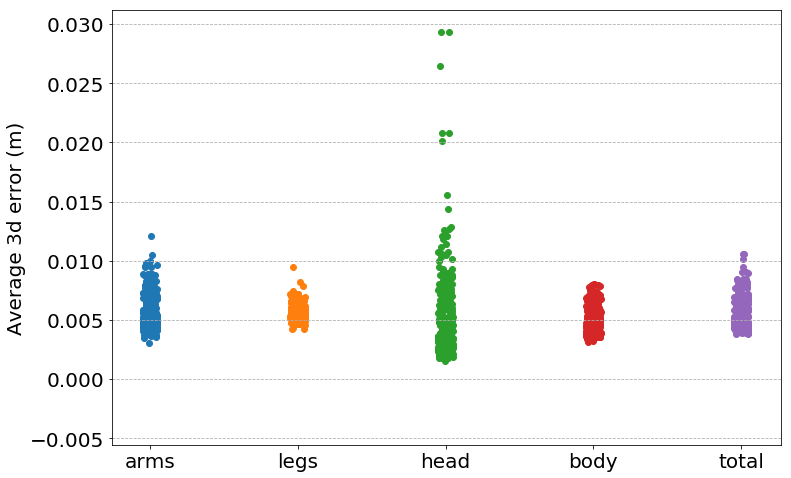

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['font.size'] = 20
for i, part in enumerate(rats[0].parts.keys()):
    vals = [diff['mean_' + part] for diff in deltas]
    jitter = (np.random.rand(len(vals))-.5)*.1
    plt.scatter((i + jitter)*np.ones_like(vals), vals)
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=rats[0].parts.keys())
plt.ylabel('Average 3d error (m)')
plt.grid(axis='y', linestyle='--')

## Calculate median link distances for skeleton and simulated rat in snippets

In [7]:
real_dists = {}
sim_dists = {}
real, sim = rats[0].skeleton_dists()
for name, dist in real.items():
    real_dists[name] = []
    sim_dists[name] = []

for rat in rats:
    real, sim = rat.skeleton_dists()
    for name, dist in real.items():
        real_dists[name].append(np.nanmedian(dist))
    for name, dist in sim.items():
        sim_dists[name].append(np.nanmedian(dist))

## Look at median distances for individual snippets

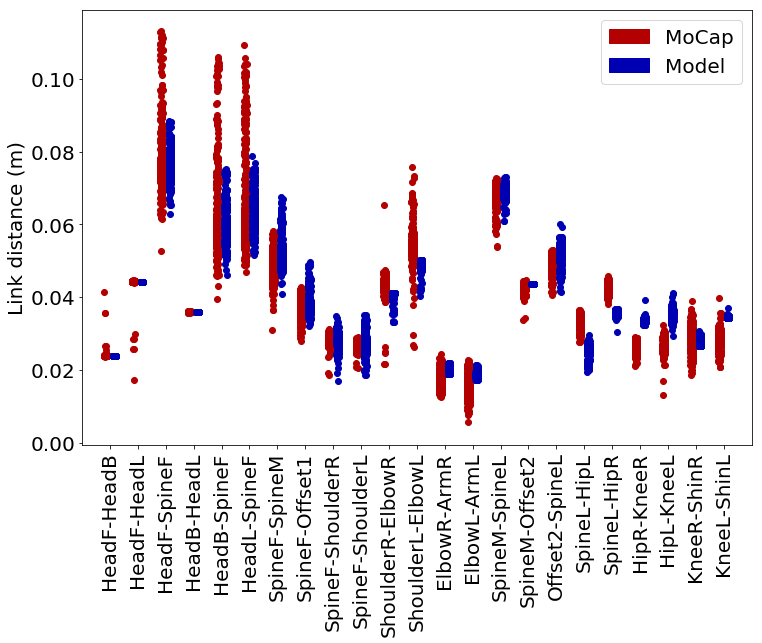

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams['font.size'] = 20
jitter_width = .1
jitter_offset = .15
for i, (name, dists) in enumerate(real_dists.items()):
    jitter = (np.random.rand(len(dists))-.5)*jitter_width - jitter_offset
    plt.scatter((i + jitter)*np.ones_like(dists), dists, color=[.7, 0, 0])
    
for i, (name, dists) in enumerate(sim_dists.items()):
    jitter = (np.random.rand(len(dists))-.5)*jitter_width + jitter_offset
    plt.scatter((i + jitter)*np.ones_like(dists), dists, color=[0, 0, .7])

plt.ylabel('Link distance (m)')
plt.xlim([-1, len(sim_dists.keys())])
plt.xticks(ticks=np.arange(len(sim_dists.keys())), labels=sim_dists.keys(), rotation=90)

red_patch = matplotlib.patches.Patch(color=[.7, 0, 0], label='MoCap')
blue_patch = matplotlib.patches.Patch(color=[0, 0, .7], label='Model')

l = plt.legend(handles=[red_patch, blue_patch])

# Look at distribution of median distances across snippets

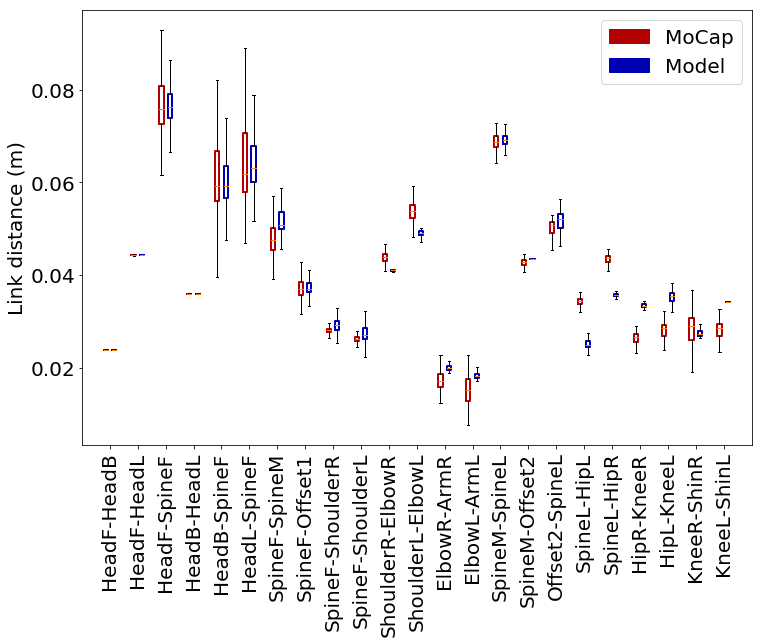

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams['font.size'] = 20
jitter_width = .1
jitter_offset = .15
real_color = [.7, 0, 0]
sim_color = [0, 0, .7]
real_bp = {'color': real_color,'linewidth': 2}
sim_bp = {'color': sim_color,'linewidth': 2}

for i, (name, dists) in enumerate(real_dists.items()):
    h_real = plt.boxplot(dists, positions=[i-jitter_offset], showfliers=False, boxprops=real_bp)
    
for i, (name, dists) in enumerate(sim_dists.items()):
    h_sim = plt.boxplot(dists, positions=[i+jitter_offset], showfliers=False, boxprops=sim_bp)

plt.ylabel('Link distance (m)')
plt.xlim([-1, len(sim_dists.keys())])
plt.xticks(ticks=np.arange(len(sim_dists.keys())), labels=sim_dists.keys(), rotation=90)

red_patch = matplotlib.patches.Patch(color=[.7, 0, 0], label='MoCap')
blue_patch = matplotlib.patches.Patch(color=[0, 0, .7], label='Model')

l = plt.legend(handles=[red_patch, blue_patch])
